# MNIST Digit Classification with Convolutional Neural Network (CNN)

**Discipline(s):** Computer Vision, Deep Learning

colab에서 돌릴 경우, 런타임 유형을 GPU로 변경해주세요.

## 1. Import Statements

---



In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

## 2. Data Preprocessing

---



The first step is to preprocess our data.

In [5]:
BATCH_SIZE =64
EPOCHS =3
LEARNING_RATE =0.01
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [7]:
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
X_train = train_dataset.data
y_train = train_dataset.targets
X_test = test_dataset.data
y_test = test_dataset.targets

print("Training Images:", X_train.shape)  # [60000, 28, 28]
print("Testing Images:", X_test.shape)    # [10000, 28, 28]
print("Training Labels:", y_train.shape)  # [60000]

print("Test Labels:", y_test.shape)       # [10000]

Training Images: torch.Size([60000, 28, 28])
Testing Images: torch.Size([10000, 28, 28])
Training Labels: torch.Size([60000])
Test Labels: torch.Size([10000])


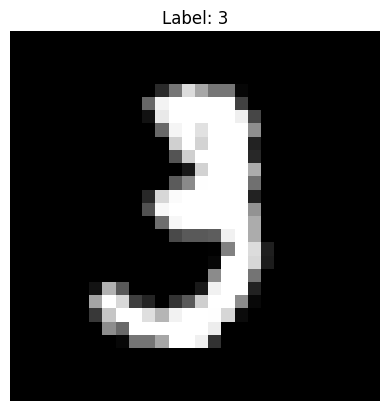

In [9]:
plt.imshow(X_train[10], cmap='gray')
plt.title(f"Label: {y_train[10].item()}")
plt.axis('off')
plt.show()

## 3. Convolutional Neural Network (CNN)

---



### 3.1. Define the Model

We then have to define our convolutional neural network.

In [10]:
# CNN 모델 정의 -> 차원이 어떻게 될지 생각하면서 코드 빈칸을 채워주세요.
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # 모델을 더 깊게 쌓아도 됩니다.
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # fully connected layer 전, flatten 과정 필요
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128,10)
        )

    def forward(self, x):
        return self.net(x)

In [11]:
# 모델 준비
model = SimpleCNN().to(DEVICE)

Once our model is defined, we can compile it using the Adam optimizer and the categorical cross-entropy loss function.

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### 3.2. Train the Model

In [13]:
def train(model, loader):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y.size(0)
        correct += (output.argmax(dim=1) == y).sum().item()
        total += y.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [14]:
def evaluate(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            output = model(x)
            loss = criterion(output, y)

            total_loss += loss.item() * y.size(0)
            correct += (output.argmax(dim=1) == y).sum().item()
            total += y.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [15]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader)
    test_loss, test_acc = evaluate(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"[Epoch {epoch+1}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

[Epoch 1] Train Loss: 0.3200, Train Acc: 0.8980 | Test Loss: 0.1728, Test Acc: 0.9437
[Epoch 2] Train Loss: 0.1619, Train Acc: 0.9502 | Test Loss: 0.1522, Test Acc: 0.9513
[Epoch 3] Train Loss: 0.1386, Train Acc: 0.9574 | Test Loss: 0.1275, Test Acc: 0.9572


### 3.3. 시각화

Finally, we can plot the curves.

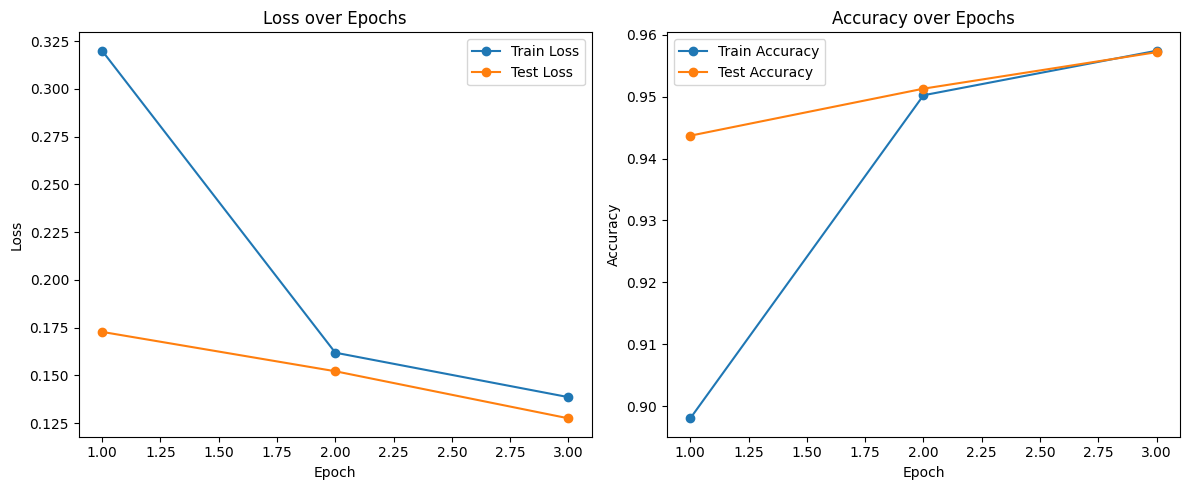

In [16]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

## 4. Make a Prediction

---



Once our model is trained, we can use it to make predictions. To do this, we first use our test set to predict the classes.

In [17]:
def show_random_predictions(model, dataset, num_images=5):
    model.eval()

    indices = random.sample(range(len(dataset)), num_images)
    images = torch.stack([dataset[i][0] for i in indices])
    labels = torch.tensor([dataset[i][1] for i in indices])

    images = images.to(DEVICE)
    outputs = model(images)
    preds = outputs.argmax(dim=1)

    plt.figure(figsize=(12, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title(f"GT: {labels[i].item()}\nPred: {preds[i].item()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Finally, we can show a random test image with its corresponding prediction.

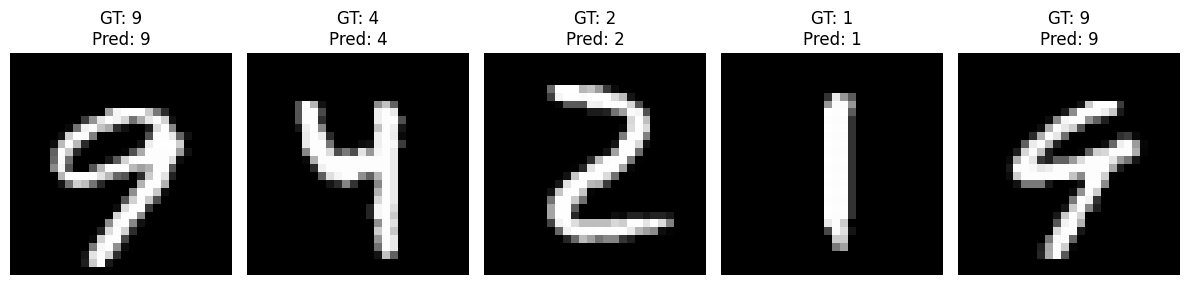

In [18]:
show_random_predictions(model, test_dataset, num_images=5)

## ResNet

In [19]:
BATCH_SIZE = 64
EPOCHS = 3
LEARNING_RATE = 0.01
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1)
        # batch normalization
        self.b1=nn.BatchNorm2d(out_channels)
        self.relu=nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1)
        self.b2=nn.BatchNorm2d(out_channels)
        
        # 추가로 layer 등을 더 구현하셔도 됩니다.


        # Skip connection: 채널 수가 다르면 어떤 convolution layer를 사용하는게 좋을지 생각해주세요.
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)

        # 빈칸 채우기
        out = self.conv1(x)
        out = self.b1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.b2(out)
        out += identity
        return self.relu(out)

In [21]:
class ResNetLike(nn.Module):
    def __init__(self):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # layer 등을 추가로 더 쌓으셔도 됩니다.
        self.layer1 = ResidualBlock(in_channels=16, out_channels=32)
        self.layer2 = ResidualBlock(in_channels=32, out_channels=64)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # 빈칸을 채워주세요.
        self.fc = nn.Linear(64,10)

    def forward(self, x):
        # 빈칸을 채워주세요.
        out = self.stem(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1) 
        out = self.fc(out)
        return out

In [22]:
model = ResNetLike().to(DEVICE)

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [24]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader)
    test_loss, test_acc = evaluate(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"[Epoch {epoch+1}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

[Epoch 1] Train Loss: 0.1621, Train Acc: 0.9524 | Test Loss: 0.0734, Test Acc: 0.9753
[Epoch 2] Train Loss: 0.0549, Train Acc: 0.9835 | Test Loss: 0.0458, Test Acc: 0.9872
[Epoch 3] Train Loss: 0.0438, Train Acc: 0.9863 | Test Loss: 0.0364, Test Acc: 0.9884


### 시각화

Finally, we can plot the curves.

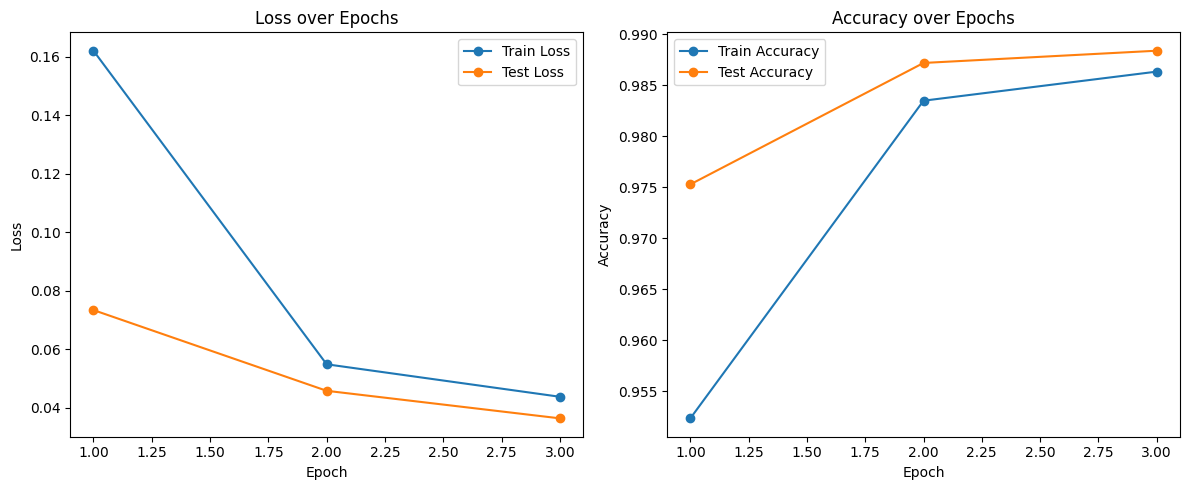

In [25]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

### Make a Prediction

---



Once our model is trained, we can use it to make predictions. To do this, we first use our test set to predict the classes.

In [26]:
def show_random_predictions(model, dataset, num_images=5):
    model.eval()

    indices = random.sample(range(len(dataset)), num_images)
    images = torch.stack([dataset[i][0] for i in indices])
    labels = torch.tensor([dataset[i][1] for i in indices])

    images = images.to(DEVICE)
    outputs = model(images)
    preds = outputs.argmax(dim=1)

    plt.figure(figsize=(12, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title(f"GT: {labels[i].item()}\nPred: {preds[i].item()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Finally, we can show a random test image with its corresponding prediction.

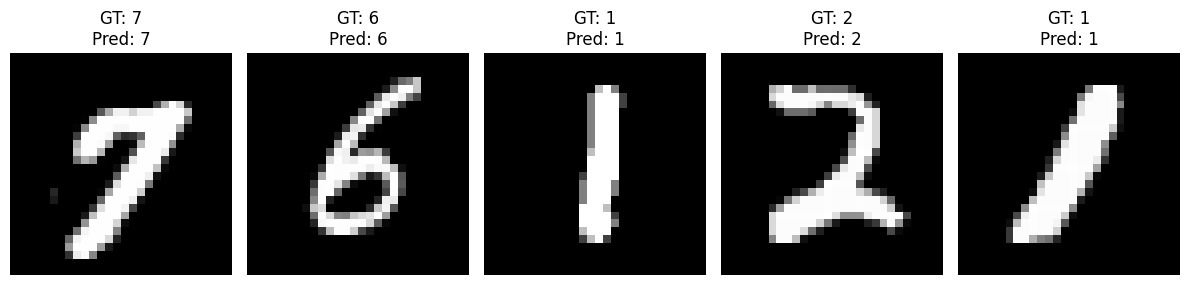

In [27]:
show_random_predictions(model, test_dataset, num_images=5)

# 다른 데이터셋으로도 진행해보기

In [28]:
BATCH_SIZE =64
EPOCHS =4
LEARNING_RATE=0.0005
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Normalize((0.3,), (0.5,))
])

In [30]:
def train(model, loader):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y.size(0)
        correct += (output.argmax(dim=1) == y).sum().item()
        total += y.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [31]:
def evaluate(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            output = model(x)
            loss = criterion(output, y)

            total_loss += loss.item() * y.size(0)
            correct += (output.argmax(dim=1) == y).sum().item()
            total += y.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [32]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader)
    test_loss, test_acc = evaluate(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"[Epoch {epoch+1}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

[Epoch 1] Train Loss: 0.0362, Train Acc: 0.9889 | Test Loss: 0.0275, Test Acc: 0.9909
[Epoch 2] Train Loss: 0.0307, Train Acc: 0.9903 | Test Loss: 0.0258, Test Acc: 0.9912
[Epoch 3] Train Loss: 0.0279, Train Acc: 0.9916 | Test Loss: 0.0189, Test Acc: 0.9937
[Epoch 4] Train Loss: 0.0271, Train Acc: 0.9915 | Test Loss: 0.0297, Test Acc: 0.9902


In [33]:
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [34]:
model = ResNetLike().to(DEVICE)

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [36]:
def show_random_predictions(model, dataset, num_images=5):
    model.eval()

    indices = random.sample(range(len(dataset)), num_images)
    images = torch.stack([dataset[i][0] for i in indices])
    labels = torch.tensor([dataset[i][1] for i in indices])

    images = images.to(DEVICE)
    outputs = model(images)
    preds = outputs.argmax(dim=1)

    plt.figure(figsize=(12, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title(f"GT: {labels[i].item()}\nPred: {preds[i].item()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

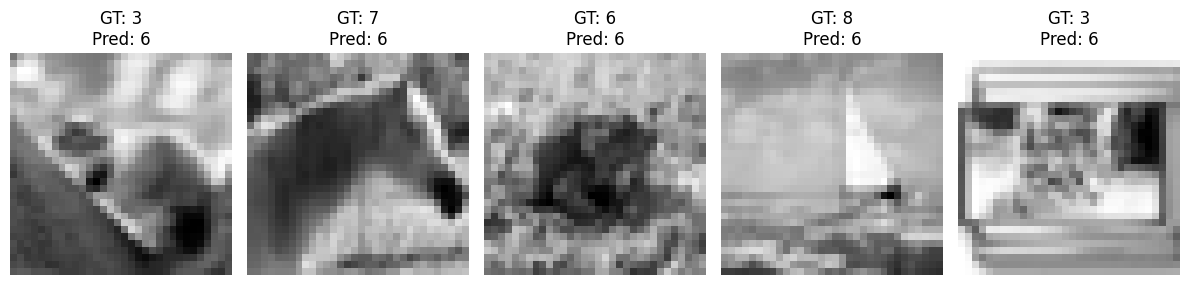

In [42]:
show_random_predictions(model, test_dataset, num_images=5)
#학습이 잘 되지 않는 문제 발생...